## Fruits-360

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
from skimage.feature import hog
import seaborn as sns
import cv2
import pandas as pd

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_classif

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

In [2]:
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(root='./data/fruits-360/Training', transform=train_transform)
test_dataset = datasets.ImageFolder(root='./data/fruits-360/Test', transform=test_transform)

print(len(train_dataset), len(test_dataset))
print(train_dataset[0][0].shape)

70491 23619
torch.Size([1, 100, 100])


In [3]:
train_images_list, train_labels_list = [], []

for images, labels in DataLoader(train_dataset, batch_size=128):
    train_images_list.append(images.numpy())
    train_labels_list.append(labels.numpy())

train_np = np.concatenate(train_images_list, axis=0).transpose(0, 2, 3, 1).squeeze(axis=-1)
train_labels = np.concatenate(train_labels_list, axis=0)


test_images_list, test_labels_list = [], []

for images, labels in DataLoader(test_dataset, batch_size=128):
    test_images_list.append(images.numpy())
    test_labels_list.append(labels.numpy())

test_np = np.concatenate(test_images_list, axis=0).transpose(0, 2, 3, 1).squeeze(axis=-1)
test_labels = np.concatenate(test_labels_list, axis=0)

print(train_np.shape, train_labels.shape)
print(test_np.shape, test_labels.shape)
print(len(np.unique(train_labels)))

# ~1m 20s

(70491, 100, 100) (70491,)
(23619, 100, 100) (23619,)
141


## Feature Extraction

In [4]:
def extract_hog_features(images):
    hog_features = []
    
    for img in images:
        features = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9, visualize=False)
        hog_features.append(features)
        
    return np.array(hog_features)

train_hog = extract_hog_features(train_np)
test_hog = extract_hog_features(test_np)

print(train_hog.shape)

# ~5m 11s

(70491, 4356)


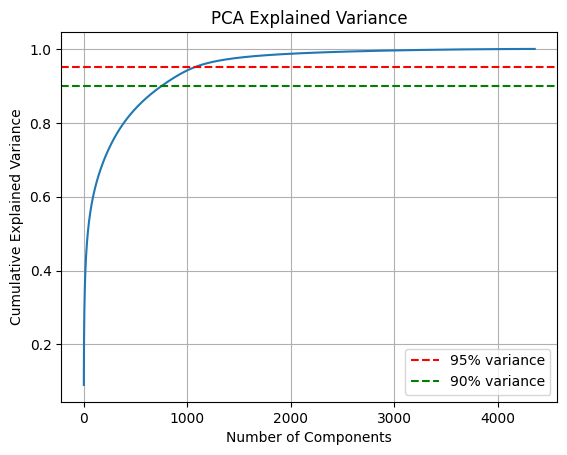

Number of components for 95% variance: 1067
Number of components for 90% variance: 754


In [5]:
pca = PCA()
pca.fit(train_hog)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.axhline(y=0.9, color='g', linestyle='--', label='90% variance')
plt.legend()
plt.grid()
plt.show()

n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Number of components for 95% variance: {n_components_95}")
print(f"Number of components for 90% variance: {n_components_90}")

# ~1m 20s

In [6]:
n_components = n_components_95
pca = PCA(n_components=n_components)

train_pca = pca.fit_transform(train_hog)
test_pca = pca.transform(test_hog)

print(train_pca.shape, test_pca.shape)

# ~33s

(70491, 1067) (23619, 1067)


## Feature Visualization

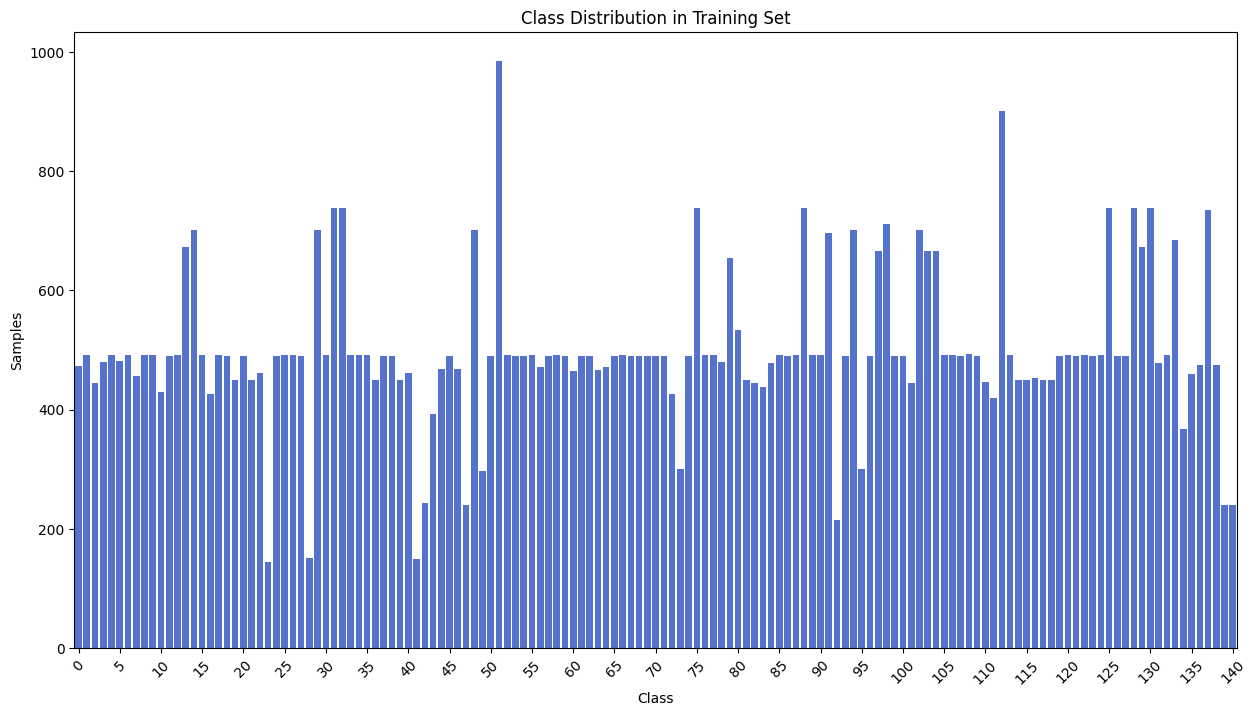

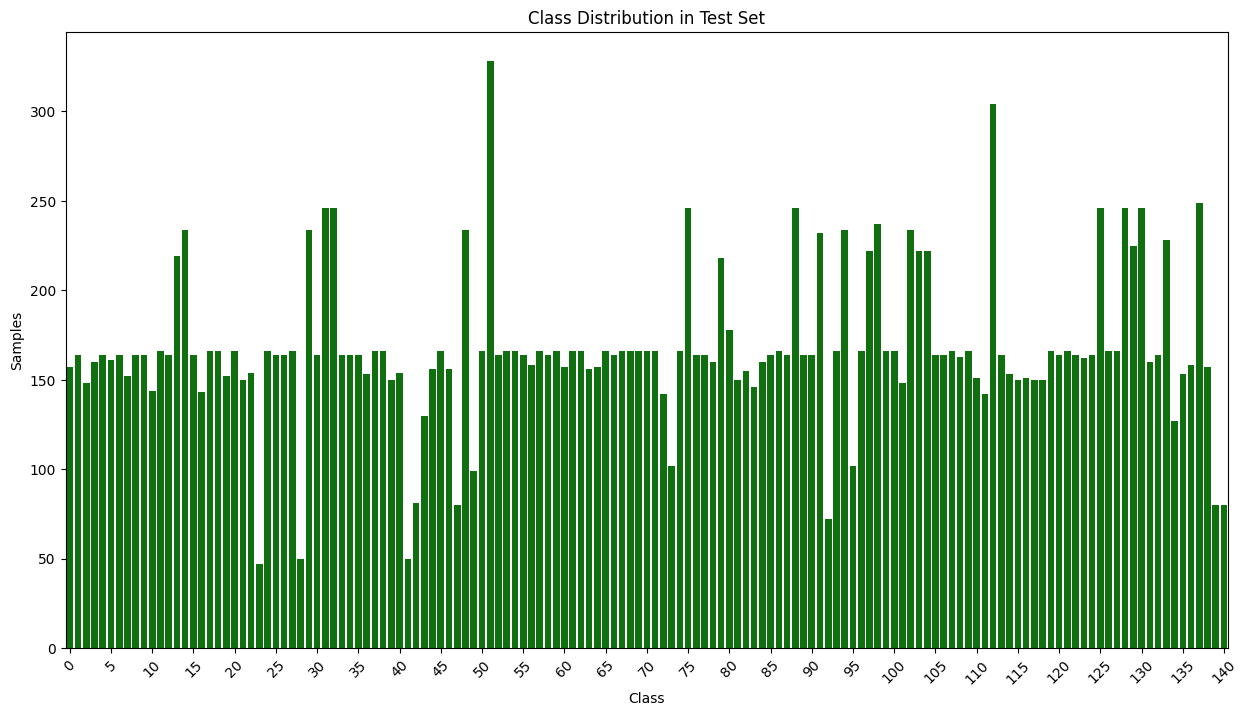

In [7]:
train_label_counts = np.bincount(train_labels)
test_label_counts = np.bincount(test_labels)

labels = np.arange(len(train_label_counts))
label_spacing = 5
spaced_labels = labels[::label_spacing]
spaced_positions = np.arange(len(labels))[::label_spacing]

plt.figure(figsize=(15, 8))
sns.barplot(x=labels, y=train_label_counts, color="royalblue")
plt.xlabel("Class")
plt.ylabel("Samples")
plt.title("Class Distribution in Training Set")
plt.xticks(spaced_positions, spaced_labels, rotation=45)
plt.show()

plt.figure(figsize=(15, 8))
sns.barplot(x=labels, y=test_label_counts, color="green")
plt.xlabel("Class")
plt.ylabel("Samples")
plt.title("Class Distribution in Test Set")
plt.xticks(spaced_positions, spaced_labels, rotation=45)
plt.show()

# ~1s

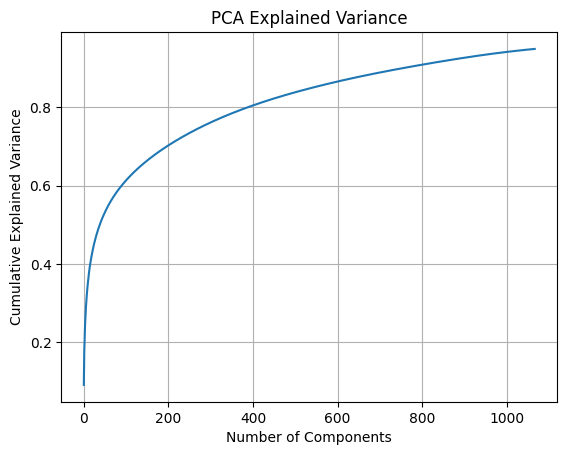

In [8]:
explained_variance = pca.explained_variance_ratio_
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()

# ~0s

Top 10 classes: [ 51 112 130  32  75  31  88 125 128 137]


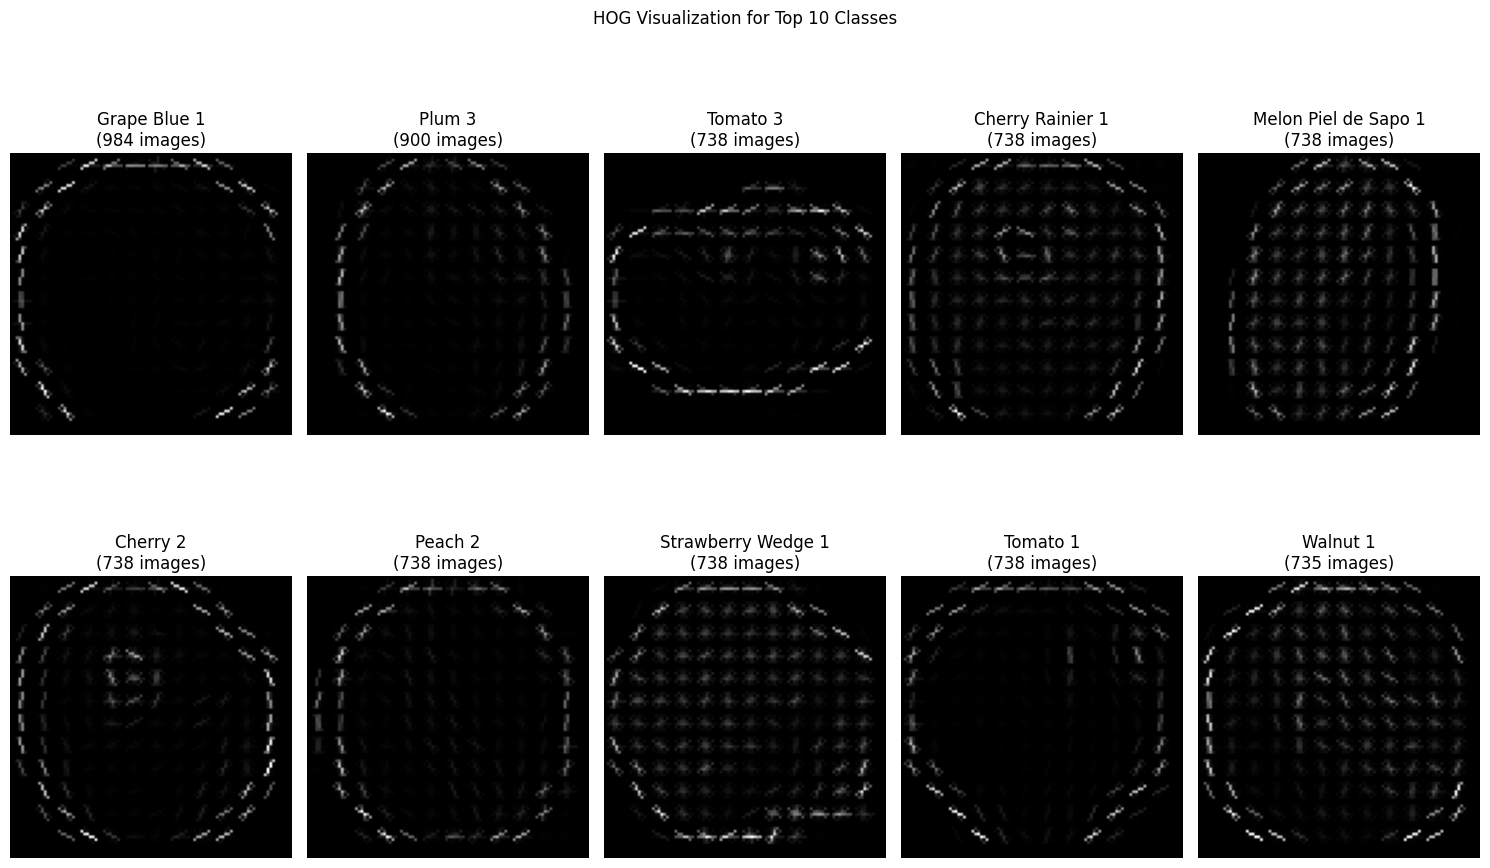

In [9]:
class_counts = np.bincount(train_labels)
sorted_classes = np.argsort(class_counts)[::-1]

top_10_classes = sorted_classes[:10]
print(f"Top 10 classes: {top_10_classes}")

plt.figure(figsize=(15, 10))

for i, label in enumerate(top_10_classes):

    img_index = np.where(train_labels == label)[0][0]
    image = train_np[img_index]

    features, hog_image = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9, visualize=True)

    plt.subplot(2, 5, i + 1)
    plt.imshow(hog_image, cmap='gray')
    plt.title(f"{train_dataset.classes[int(label)]}\n({class_counts[label]} images)")
    plt.axis("off")

plt.suptitle("HOG Visualization for Top 10 Classes")
plt.tight_layout()
plt.show()

# ~0.8s

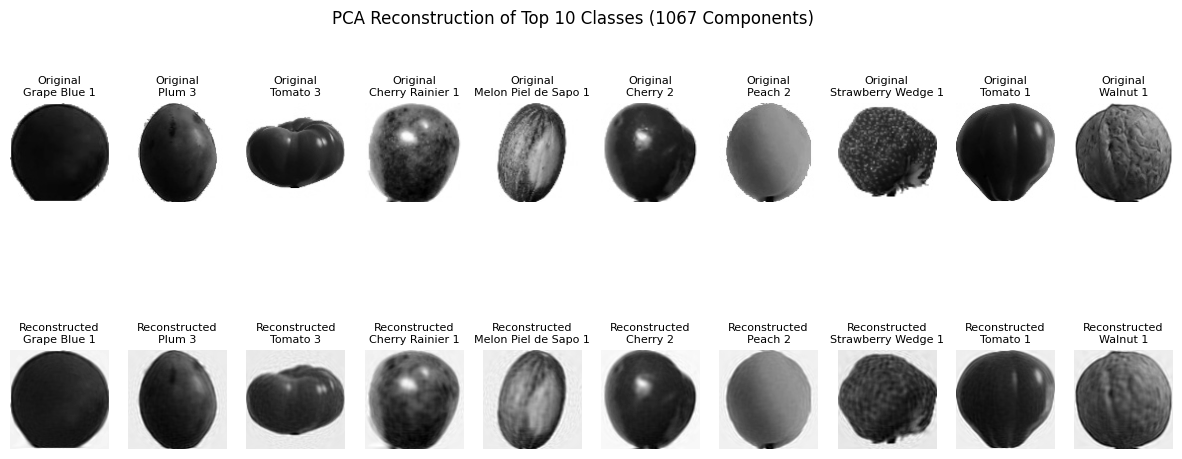

In [10]:
unique_classes = np.unique(train_labels)

train_flat = train_np.reshape(train_np.shape[0], -1)

pca = PCA(n_components=n_components_95)
pca.fit(train_flat)

plt.figure(figsize=(15, 5.5))

for i, label in enumerate(top_10_classes):

    img_index = np.where(train_labels == label)[0][0]
    original_image = train_flat[img_index]

    reduced_features = pca.transform([original_image])
    reconstructed_image = pca.inverse_transform(reduced_features)

    original_image_reshaped = original_image.reshape(100, 100)
    reconstructed_image_reshaped = reconstructed_image.reshape(100, 100)

    plt.subplot(2, 10, i + 1)
    plt.imshow(original_image_reshaped, cmap='gray')
    plt.title(f"Original\n{train_dataset.classes[int(label)]}", fontsize=8)
    plt.axis("off")

    plt.subplot(2, 10, 10 + i + 1)
    plt.imshow(reconstructed_image_reshaped, cmap='gray')
    plt.title(f"Reconstructed\n{train_dataset.classes[int(label)]}", fontsize=8)
    plt.axis("off")

plt.suptitle(f"PCA Reconstruction of Top 10 Classes ({n_components_95} Components)")
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()

# ~1m 22s

## Standardization and Feature Selection

In [11]:
scaler = StandardScaler()
train_pca_scaled = scaler.fit_transform(train_pca)
test_pca_scaled = scaler.transform(test_pca)

print(f"Shape before selection: {train_pca_scaled.shape}")

# ~0.9s

Shape before selection: (70491, 1067)


In [12]:
threshold = 0.01
selector_variance = VarianceThreshold(threshold=threshold)
train_selected_variance = selector_variance.fit_transform(train_pca_scaled)
test_selected_variance = selector_variance.transform(test_pca_scaled)

print(f"Shape after Variance Threshold: {train_selected_variance.shape}")

# ~5.2s

Shape after Variance Threshold: (70491, 1067)


In [13]:
percentile = 50
selector_percentile = SelectPercentile(score_func=f_classif, percentile=percentile)
train_selected_percentile = selector_percentile.fit_transform(train_selected_variance, train_labels)
test_selected_percentile = selector_percentile.transform(test_selected_variance)

print(f"Shape after Select Percentile: {train_selected_percentile.shape}")

# ~0.6s

Shape after Select Percentile: (70491, 533)


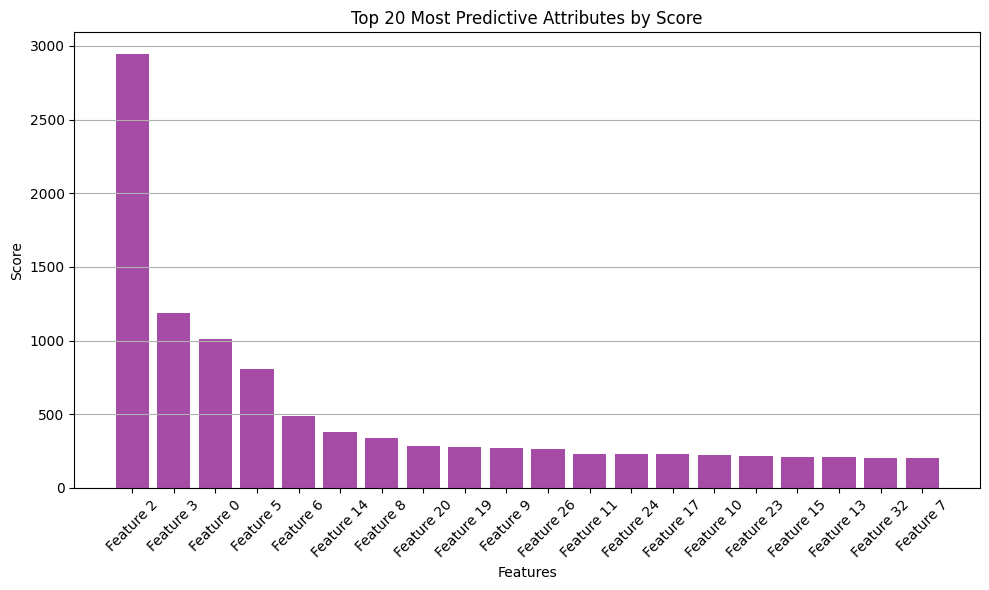

In [16]:
scores = selector_percentile.scores_
top_indices = np.argsort(scores)[::-1][:20]  # Indices of top 10 features

plt.figure(figsize=(10, 6))
plt.bar(range(20), scores[top_indices], color='purple', alpha=0.7)
plt.xticks(range(20), [f"Feature {i}" for i in top_indices], rotation=45)
plt.xlabel("Features")
plt.ylabel("Score")
plt.title("Top 20 Most Predictive Attributes by Score")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

## Using Machine Learning Algoirthms for Predictions

In [17]:
X_train = train_selected_percentile
X_test = test_selected_percentile
y_train = train_labels
y_test = test_labels

In [18]:
def remap_labels(labels, class_names, class_to_group):
    return [class_to_group[class_names[label]] for label in labels]

def plot_grouped_confusion_matrix(model_name, y_true, y_pred, class_names):

    group_names = [name.split()[0] for name in class_names]
    class_to_group = {class_name: group for class_name, group in zip(class_names, group_names)}

    y_true_grouped = remap_labels(y_true, class_names, class_to_group)
    y_pred_grouped = remap_labels(y_pred, class_names, class_to_group)

    unique_groups = sorted(set(group_names))
    grouped_cm = confusion_matrix(y_true_grouped, y_pred_grouped, labels=unique_groups)

    plt.figure(figsize=(22, 10))
    sns.heatmap(grouped_cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_groups, yticklabels=unique_groups)
    plt.title(f'Grouped Confusion Matrix: {model_name}')
    plt.xlabel('Predicted Group')
    plt.ylabel('True Group')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    

In [ ]:
#param_grid_lr = {
#    "C": [0.001, 0.01, 0.1, 1, 10],
#    "solver": ["lbfgs"],
#    'multi_class': ['ovr', 'multinomial']
#}

#clf_lr = RandomizedSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=3, n_iter=5, n_jobs=-1)
#clf_lr.fit(X_train, y_train)

#y_pred_lr = clf_lr.predict(X_test)
#print("Logistic Regression Best Params:", clf_lr.best_params_)
#print(classification_report(y_test, y_pred_lr))
#plot_confusion_matrix("Logistic Regression", y_test, y_pred_lr, class_labels=np.unique(y_test))


# ~1m 36s
#Logistic Regression Best Params: {'solver': 'lbfgs', 'C': 10}

In [19]:
clf_lr = LogisticRegression(C=10, solver='lbfgs', max_iter=1000)
clf_lr.fit(X_train, y_train)

y_pred_lr = clf_lr.predict(X_test)

# ~12s

                       precision    recall  f1-score   support

              Apple 6       0.99      1.00      0.99       157
     Apple Braeburn 1       0.80      0.66      0.73       164
 Apple Crimson Snow 1       0.81      0.97      0.88       148
       Apple Golden 1       0.92      0.89      0.90       160
       Apple Golden 2       0.97      0.80      0.88       164
       Apple Golden 3       0.93      0.71      0.81       161
 Apple Granny Smith 1       0.91      0.72      0.81       164
    Apple Pink Lady 1       0.85      0.84      0.84       152
          Apple Red 1       0.68      0.62      0.65       164
          Apple Red 2       0.65      0.70      0.67       164
          Apple Red 3       0.78      0.90      0.83       144
Apple Red Delicious 1       0.99      1.00      1.00       166
   Apple Red Yellow 1       0.67      0.55      0.60       164
   Apple Red Yellow 2       0.86      0.90      0.88       219
          Apple hit 1       0.99      1.00      1.00  

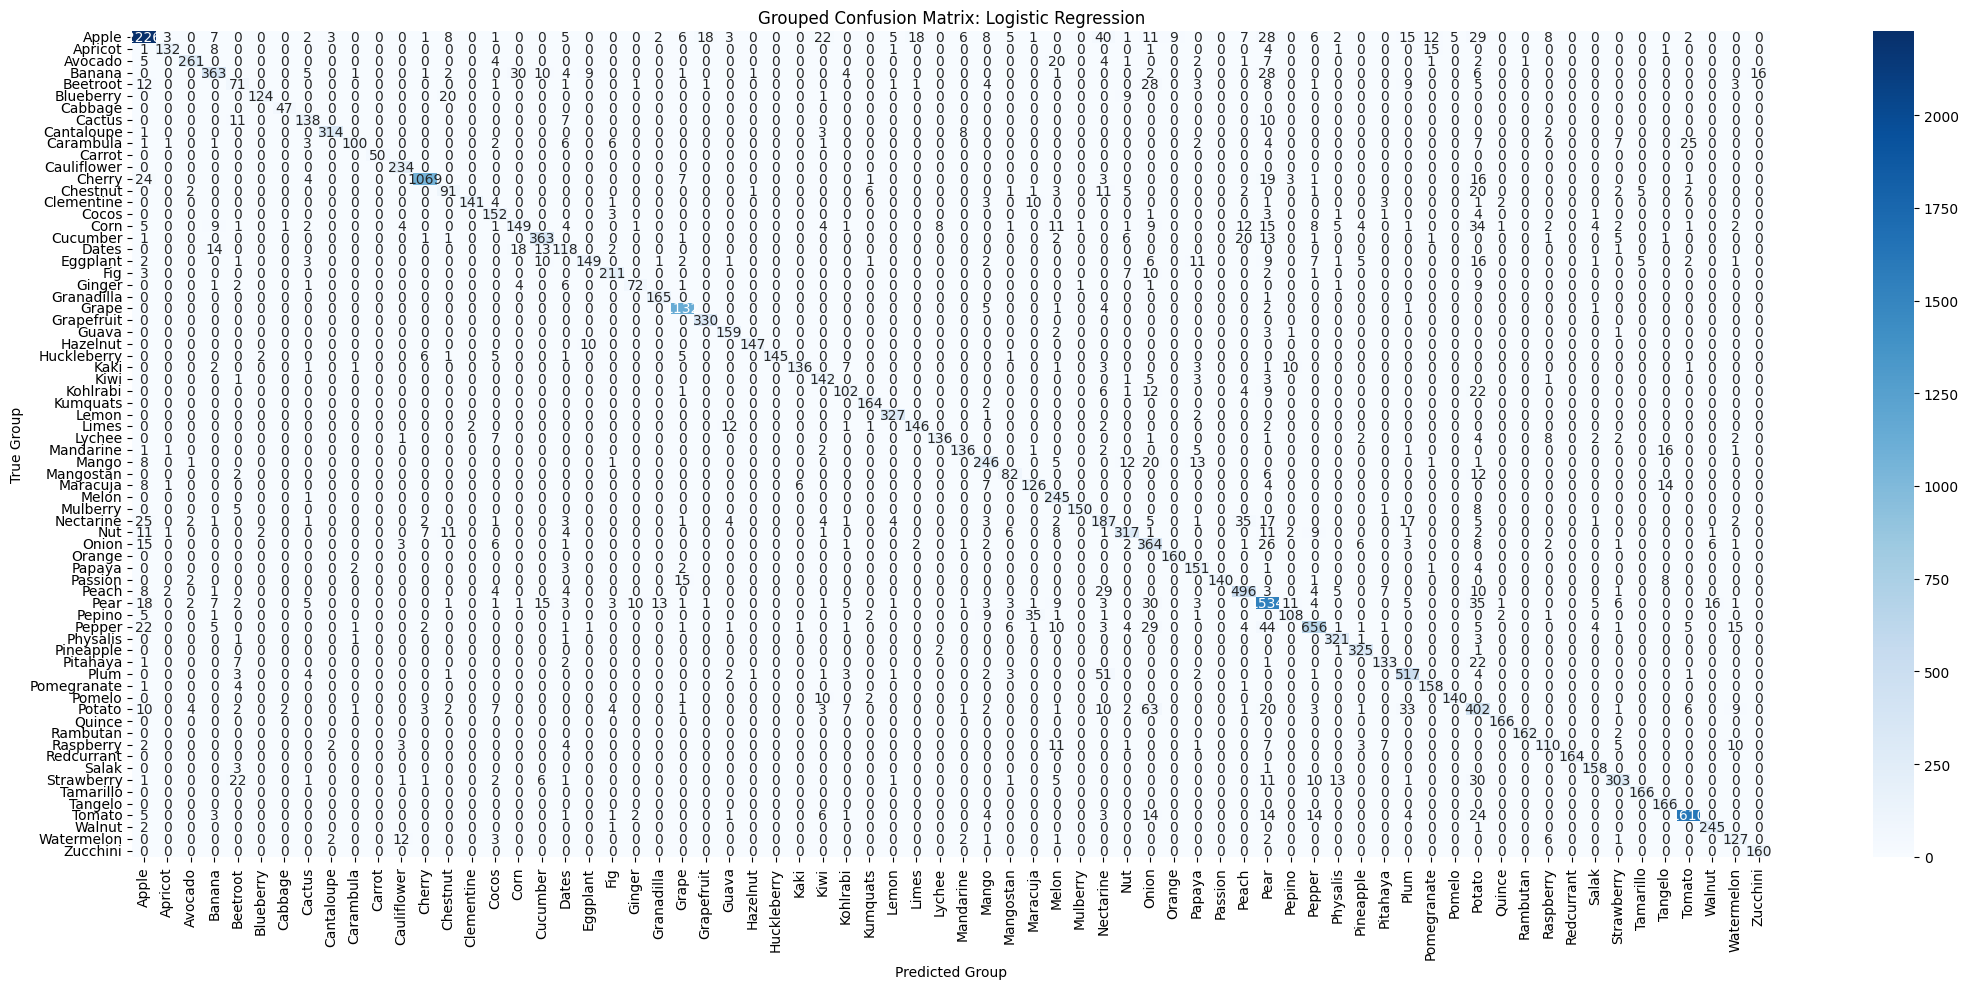

In [27]:
print(classification_report(y_test, y_pred_lr, target_names=train_dataset.classes))
plot_grouped_confusion_matrix("Logistic Regression", y_test, y_pred_lr, train_dataset.classes)

In [28]:
#param_grid_svm = {
#    "C": [0.01, 0.1, 1, 10],
#    "kernel": ["linear", "rbf"],
#    "gamma": ["scale", "auto"],
#    "class_weight": [None, "balanced"]
#}

#clf_svm = RandomizedSearchCV(SVC(), param_grid_svm, cv=3, n_iter=2, n_jobs=-1)
#clf_svm.fit(X_train, y_train)

#y_pred_svm = clf_svm.predict(X_test)
#print("SVM Best Params:", clf_svm.best_params_)
#print(classification_report(y_test, y_pred_svm))
#plot_confusion_matrix("SVM", y_test, y_pred_svm, class_labels=unique_classes)


# ~mult (6h)
#SVM Best Params: {'kernel': 'linear', 'C': 0.1}

In [29]:
clf_svm = SVC(C=0.1, kernel='linear', gamma='scale', class_weight="balanced")
clf_svm.fit(X_train, y_train)

y_pred_svm = clf_svm.predict(X_test)

# ~20m 55s

                       precision    recall  f1-score   support

              Apple 6       1.00      1.00      1.00       157
     Apple Braeburn 1       0.85      0.71      0.77       164
 Apple Crimson Snow 1       0.76      0.93      0.84       148
       Apple Golden 1       0.96      0.94      0.95       160
       Apple Golden 2       0.99      0.84      0.90       164
       Apple Golden 3       0.84      0.80      0.82       161
 Apple Granny Smith 1       0.98      0.71      0.82       164
    Apple Pink Lady 1       0.91      0.99      0.95       152
          Apple Red 1       0.74      0.77      0.75       164
          Apple Red 2       0.67      0.76      0.71       164
          Apple Red 3       0.84      0.94      0.89       144
Apple Red Delicious 1       1.00      1.00      1.00       166
   Apple Red Yellow 1       0.75      0.73      0.74       164
   Apple Red Yellow 2       0.93      0.99      0.96       219
          Apple hit 1       0.97      1.00      0.99  

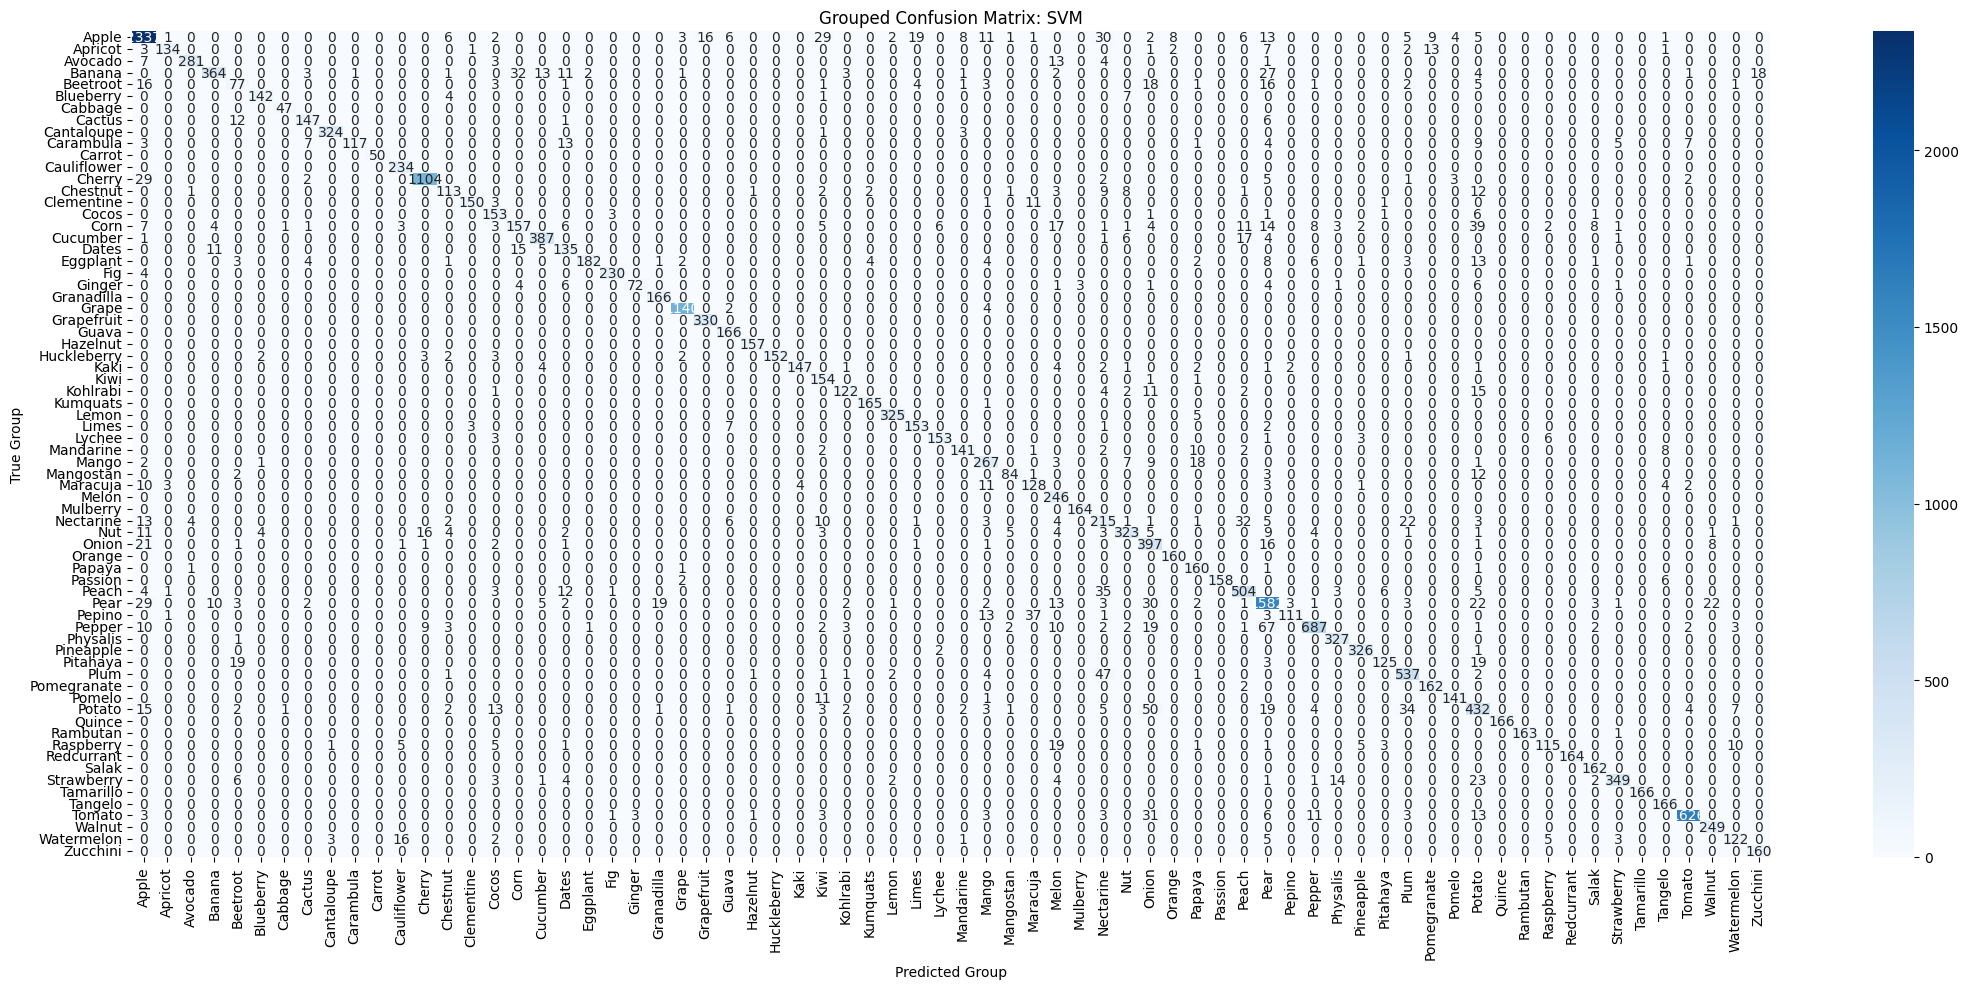

In [30]:
print(classification_report(y_test, y_pred_svm, target_names=train_dataset.classes))
plot_grouped_confusion_matrix("SVM", y_test, y_pred_svm, train_dataset.classes)

In [31]:
#param_grid_rf = {
#    "n_estimators": [100, 200],
#    "max_depth": [50, 60, 70],
#    "max_features": ["sqrt", "log2"]
#}

#clf_rf = RandomizedSearchCV(RandomForestClassifier(), param_grid_rf, cv=3, n_iter=3, n_jobs=-1)
#clf_rf.fit(X_train, y_train)

#y_pred_rf = clf_rf.predict(X_test)
#print("Random Forest Best Params:", clf_rf.best_params_)
#print(classification_report(y_test, y_pred_rf))
#plot_confusion_matrix("Random Forest", y_test, y_pred_rf, class_labels=unique_classes)

# ~mult (nu stiu nu converge..)
#Random Forest Best Params: {'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 60}

In [32]:
clf_rf = RandomForestClassifier(n_estimators=200, max_features='sqrt', max_depth=60)
clf_rf.fit(X_train, y_train)

y_pred_rf = clf_rf.predict(X_test)

# ~37m 39s

                       precision    recall  f1-score   support

              Apple 6       0.81      1.00      0.89       157
     Apple Braeburn 1       0.81      0.70      0.75       164
 Apple Crimson Snow 1       0.45      0.90      0.60       148
       Apple Golden 1       0.88      0.83      0.85       160
       Apple Golden 2       0.92      0.79      0.85       164
       Apple Golden 3       0.62      0.67      0.64       161
 Apple Granny Smith 1       0.89      0.65      0.75       164
    Apple Pink Lady 1       0.74      0.80      0.77       152
          Apple Red 1       0.78      0.49      0.60       164
          Apple Red 2       0.82      0.68      0.75       164
          Apple Red 3       0.84      0.79      0.81       144
Apple Red Delicious 1       0.97      1.00      0.99       166
   Apple Red Yellow 1       0.71      0.71      0.71       164
   Apple Red Yellow 2       0.92      0.94      0.93       219
          Apple hit 1       0.76      1.00      0.87  

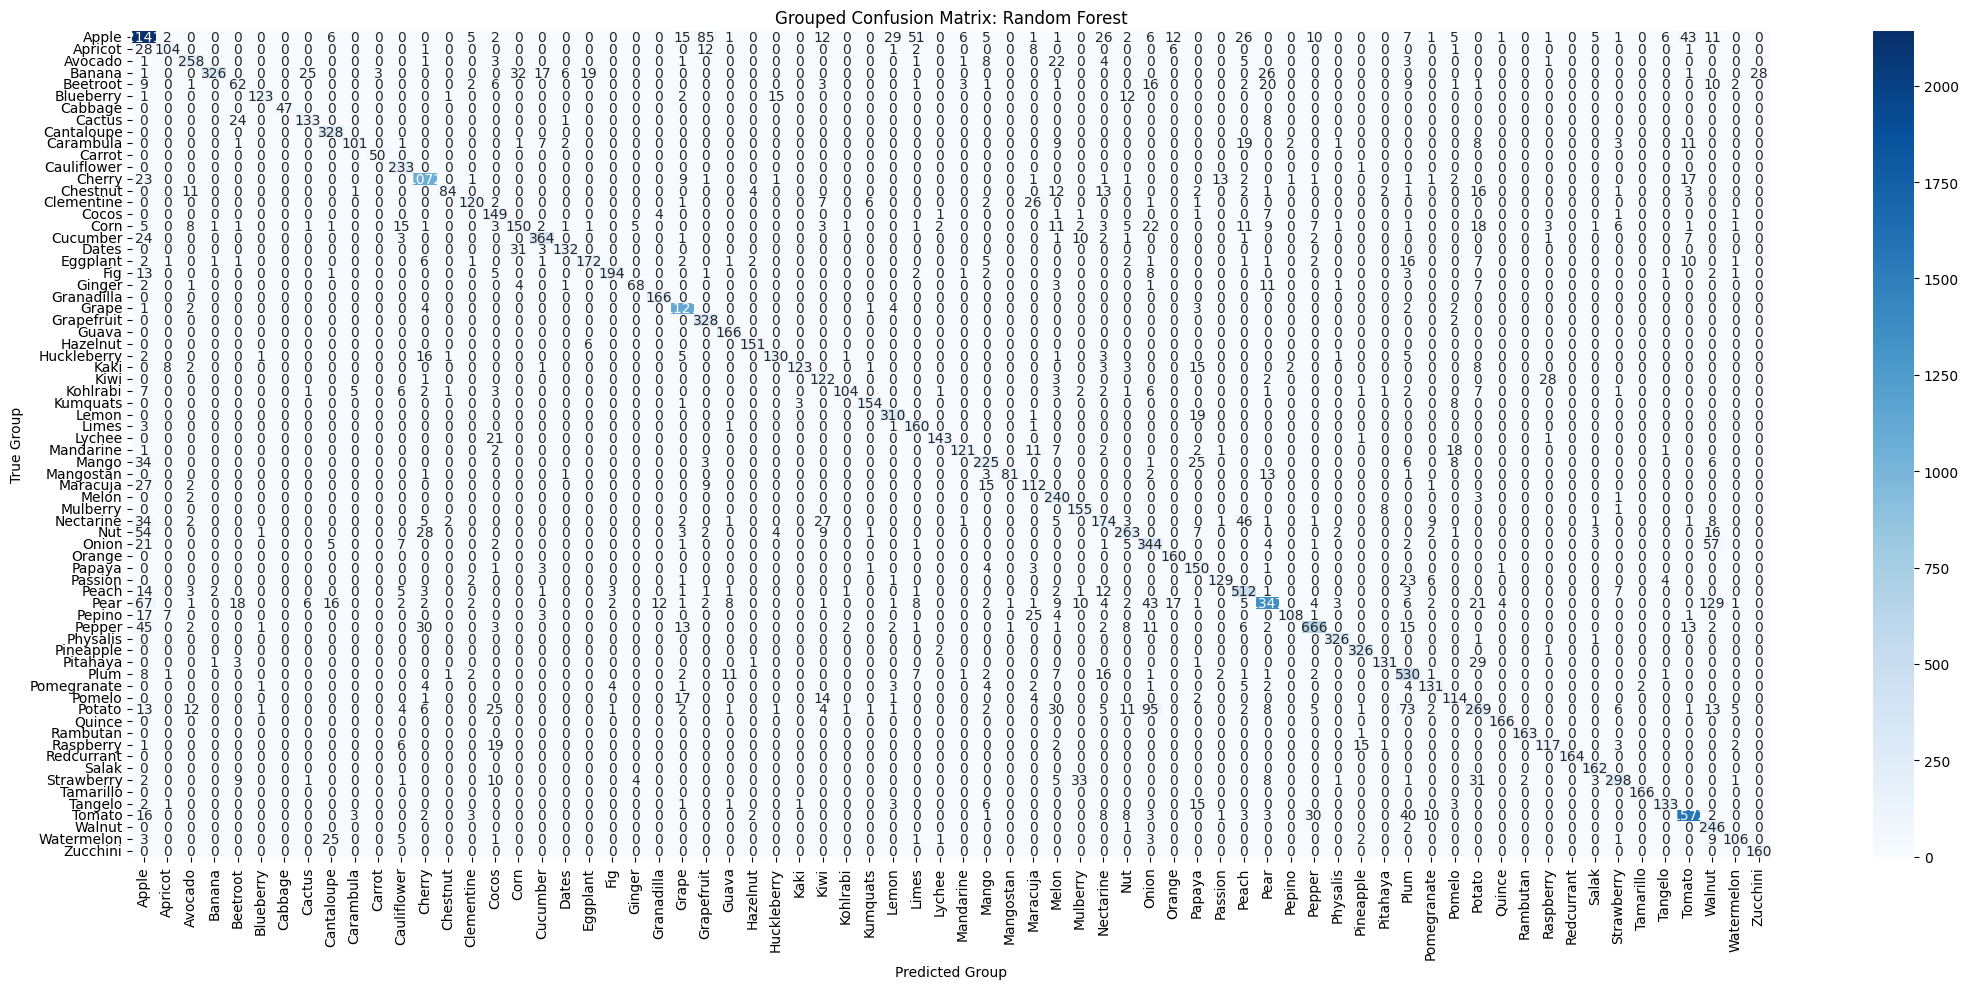

In [33]:
print(classification_report(y_test, y_pred_rf, target_names=train_dataset.classes))
plot_grouped_confusion_matrix("Random Forest", y_test, y_pred_rf, train_dataset.classes)

In [34]:
#param_grid_xgb = {
#    "n_estimators": [50, 100, 200],
#    "max_depth": [3, 6, 10],
#    "learning_rate": [0.01, 0.1]
#}

#clf_xgb = RandomizedSearchCV(XGBClassifier(use_label_encoder=False, eval_metric="logloss"), param_grid_xgb, cv=3, n_iter=3, n_jobs=-1, verbose=2)
#clf_xgb.fit(X_train[:20000], y_train[:20000])

#y_pred_xgb = clf_xgb.predict(X_test[:20000])
#print("XGBoost Best Params:", clf_xgb.best_params_)
#print(classification_report(y_test[:20000], y_pred_xgb[:20000]))
#plot_confusion_matrix("XGBoost", y_test, y_pred_xgb, class_labels=unique_classes)

# ~30m
#XGBoost Best Params: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1}

In [35]:
clf_xgb = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, eval_metric="logloss", tree_method="hist", device="cuda")
clf_xgb.fit(X_train, y_train)

y_pred_xgb = clf_xgb.predict(X_test)

# ~8m 30s (gpu)

c:\Users\Alex\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:00:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


                       precision    recall  f1-score   support

              Apple 6       0.95      1.00      0.97       157
     Apple Braeburn 1       0.85      0.63      0.72       164
 Apple Crimson Snow 1       0.49      0.83      0.61       148
       Apple Golden 1       0.78      0.83      0.80       160
       Apple Golden 2       0.84      0.68      0.75       164
       Apple Golden 3       0.64      0.78      0.71       161
 Apple Granny Smith 1       0.88      0.65      0.75       164
    Apple Pink Lady 1       0.64      0.82      0.72       152
          Apple Red 1       0.74      0.46      0.57       164
          Apple Red 2       0.69      0.63      0.66       164
          Apple Red 3       0.88      0.78      0.83       144
Apple Red Delicious 1       0.99      0.93      0.96       166
   Apple Red Yellow 1       0.57      0.58      0.57       164
   Apple Red Yellow 2       0.88      0.89      0.89       219
          Apple hit 1       0.87      1.00      0.93  

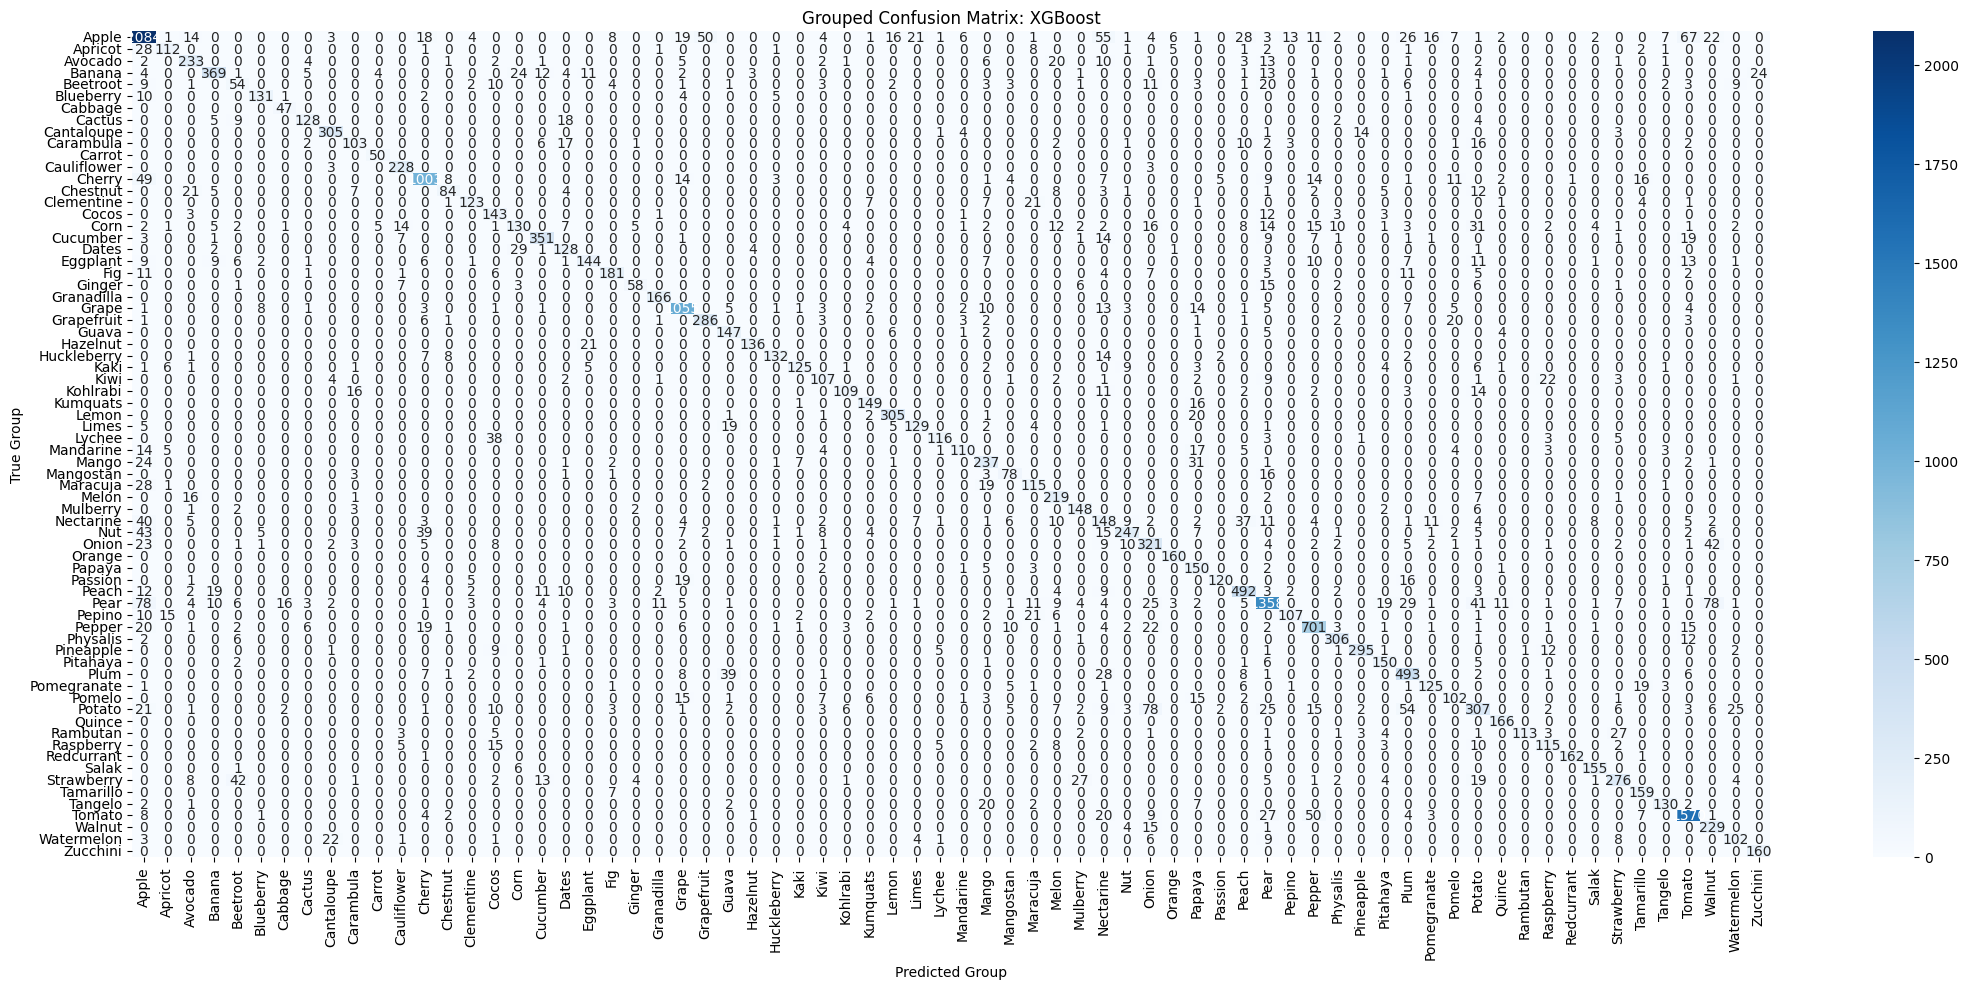

In [36]:
print(classification_report(y_test, y_pred_xgb, target_names=train_dataset.classes))
plot_grouped_confusion_matrix("XGBoost", y_test, y_pred_xgb, train_dataset.classes)

### Worst predictions

In [37]:
def top_worst_classes_report(y_true, y_pred, class_names, top_n=10, model=""):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

    report_df = pd.DataFrame(report).transpose()
    class_scores = report_df.iloc[:-3]
    
    sorted_scores = class_scores.sort_values(by="f1-score", ascending=True)
    worst_classes = sorted_scores.head(top_n)
    
    print(f"\nTop {top_n} Worst Classes ({model}) by F1 Score:\n")
    print("                    precision     recall   f1-score   support")
    for class_name, row in worst_classes.iterrows():
        print(f"{class_name:<24} {row['precision']:<10.2f} {row['recall']:<10.2f} {row['f1-score']:<10.2f} {int(row['support']):<6}")


def top_best_classes_report(y_true, y_pred, class_names, top_n=10, model=""):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

    report_df = pd.DataFrame(report).transpose()
    class_scores = report_df.iloc[:-3]
    
    sorted_scores = class_scores.sort_values(by="f1-score", ascending=False)
    best_classes = sorted_scores.head(top_n)
    
    print(f"\nTop {top_n} Best Classes ({model}) by F1 Score:\n")
    print("                    precision     recall   f1-score   support")
    for class_name, row in best_classes.iterrows():
        print(f"{class_name:<24} {row['precision']:<10.2f} {row['recall']:<10.2f} {row['f1-score']:<10.2f} {int(row['support']):<6}")




def plot_worst_classes_confusion_matrix(y_true, y_pred, class_names, top_n=10, model=""):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    
    f1_scores = {cls: report[cls]["f1-score"] for cls in class_names if cls in report}
    worst_classes = sorted(f1_scores, key=f1_scores.get)[:top_n]
    
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))
    worst_class_indices = [class_names.index(cls) for cls in worst_classes]
    filtered_cm = cm[np.ix_(worst_class_indices, worst_class_indices)]
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(filtered_cm, annot=True, fmt="d", cmap="Blues", xticklabels=worst_classes, yticklabels=worst_classes)
    plt.title(f"Confusion Matrix: {model} (Top {top_n} Worst Classes by F1 Score)")
    plt.xlabel("Predicted Classes")
    plt.ylabel("True Classes")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

def plot_best_classes_confusion_matrix(y_true, y_pred, class_names, top_n=10, model=""):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    
    f1_scores = {cls: report[cls]["f1-score"] for cls in class_names if cls in report}
    best_classes = sorted(f1_scores, key=f1_scores.get, reverse=True)[:top_n]
    
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))
    best_class_indices = [class_names.index(cls) for cls in best_classes]
    filtered_cm = cm[np.ix_(best_class_indices, best_class_indices)]
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(filtered_cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_classes, yticklabels=best_classes)
    plt.title(f"Confusion Matrix: {model} (Top {top_n} Best Classes by F1 Score)")
    plt.xlabel("Predicted Classes")
    plt.ylabel("True Classes")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


Top 20 Worst Classes (Logistic Regression) by F1 Score:

                    precision     recall   f1-score   support
Potato Red 1             0.32       0.50       0.39       150   
Pear Monster 1           0.48       0.35       0.40       166   
Nectarine 1              0.39       0.46       0.42       164   
Onion White 1            0.42       0.54       0.47       146   
Pear 2                   0.59       0.41       0.48       232   
Potato White 1           0.41       0.60       0.48       150   
Beetroot 1               0.51       0.47       0.49       150   
Corn 1                   0.71       0.40       0.51       150   
Plum 1                   0.57       0.51       0.54       151   
Potato Sweet 1           0.53       0.56       0.54       150   
Potato Red Washed 1      0.58       0.53       0.55       151   
Eggplant 1               0.84       0.44       0.58       156   
Apple Red Yellow 1       0.67       0.55       0.60       164   
Pepper Orange 1          0.85      

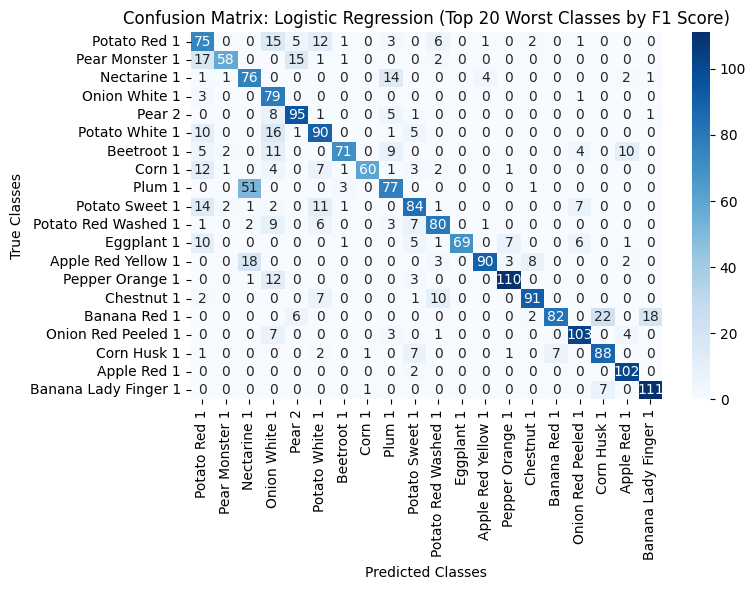

In [38]:
top_worst_classes_report(y_test, y_pred_lr, train_dataset.classes, top_n=20, model="Logistic Regression")
#top_best_classes_report(y_test, y_pred_lr, train_dataset.classes, top_n=10, model="Logistic Regression")

plot_worst_classes_confusion_matrix(y_test, y_pred_lr, train_dataset.classes, top_n=20, model="Logistic Regression", )
#plot_best_classes_confusion_matrix(y_test, y_pred_lr, train_dataset.classes, top_n=10, model="Logistic Regression")


Top 20 Worst Classes (SVM) by F1 Score:

                    precision     recall   f1-score   support
Nectarine 1              0.43       0.48       0.45       164   
Potato Red 1             0.46       0.55       0.50       150   
Corn 1                   0.76       0.42       0.54       150   
Pear Monster 1           0.62       0.50       0.55       166   
Pear 2                   0.69       0.47       0.56       232   
Beetroot 1               0.61       0.51       0.56       150   
Onion White 1            0.48       0.68       0.57       146   
Potato White 1           0.50       0.68       0.58       150   
Potato Sweet 1           0.64       0.59       0.61       150   
Potato Red Washed 1      0.69       0.58       0.63       151   
Plum 1                   0.69       0.63       0.66       151   
Banana Red 1             0.94       0.51       0.66       166   
Corn Husk 1              0.75       0.61       0.67       154   
Pepper Orange 1          0.93       0.54       0.68

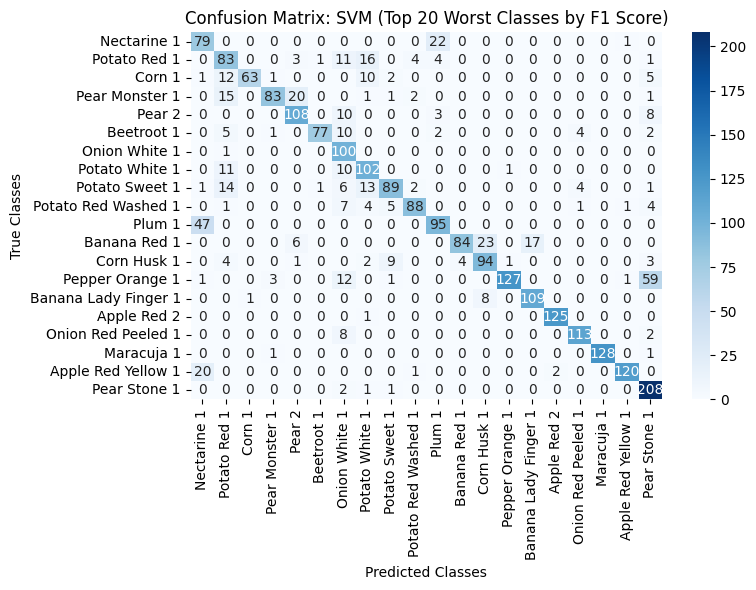

In [39]:
top_worst_classes_report(y_test, y_pred_svm, train_dataset.classes, top_n=20, model="SVM")
plot_worst_classes_confusion_matrix(y_test, y_pred_svm, train_dataset.classes, top_n=20, model="SVM")


Top 20 Worst Classes (Random Forest) by F1 Score:

                    precision     recall   f1-score   support
Potato Red 1             0.44       0.34       0.38       150   
Pear 2                   0.47       0.36       0.41       232   
Onion White 1            0.32       0.62       0.42       146   
Nectarine 1              0.50       0.38       0.43       164   
Beetroot 1               0.52       0.41       0.46       150   
Potato Sweet 1           0.52       0.42       0.46       150   
Potato Red Washed 1      0.72       0.35       0.47       151   
Corn 1                   0.61       0.39       0.48       150   
Potato White 1           0.56       0.43       0.48       150   
Onion Red Peeled 1       0.67       0.50       0.57       155   
Pear Monster 1           0.84       0.46       0.59       166   
Apple Crimson Snow 1     0.45       0.90       0.60       148   
Apple Red 1              0.78       0.49       0.60       164   
Maracuja 1               0.57       0.67 

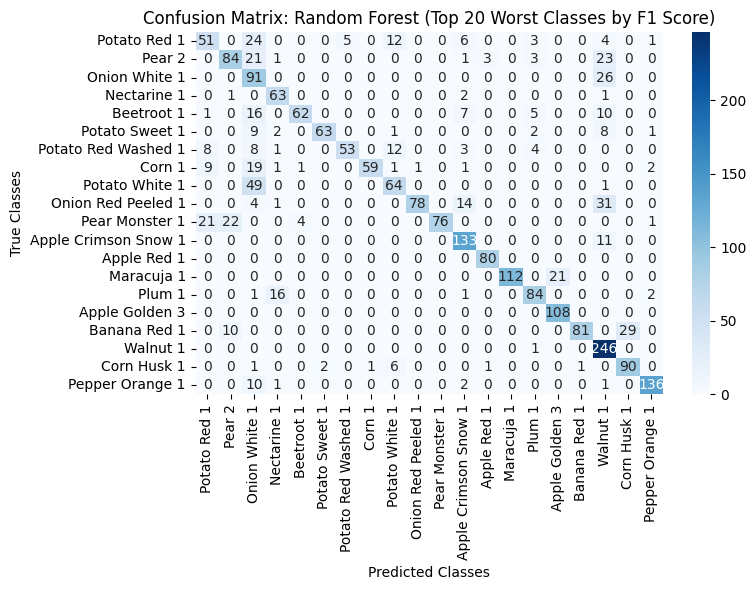

In [40]:
top_worst_classes_report(y_test, y_pred_rf, train_dataset.classes, top_n=20, model="Random Forest")
plot_worst_classes_confusion_matrix(y_test, y_pred_rf, train_dataset.classes, top_n=20, model="Random Forest")


Top 20 Worst Classes (XGBoost) by F1 Score:

                    precision     recall   f1-score   support
Nectarine 1              0.25       0.31       0.28       164   
Potato Red 1             0.36       0.37       0.37       150   
Beetroot 1               0.40       0.36       0.38       150   
Onion White 1            0.35       0.51       0.42       146   
Plum 1                   0.39       0.46       0.42       151   
Corn 1                   0.58       0.35       0.43       150   
Potato Sweet 1           0.54       0.38       0.45       150   
Pear 2                   0.54       0.41       0.46       232   
Potato White 1           0.43       0.54       0.48       150   
Potato Red Washed 1      0.68       0.38       0.49       151   
Eggplant 1               0.63       0.41       0.50       156   
Nectarine Flat 1         0.52       0.59       0.55       160   
Apple Red 1              0.74       0.46       0.57       164   
Apple Red Yellow 1       0.57       0.58       

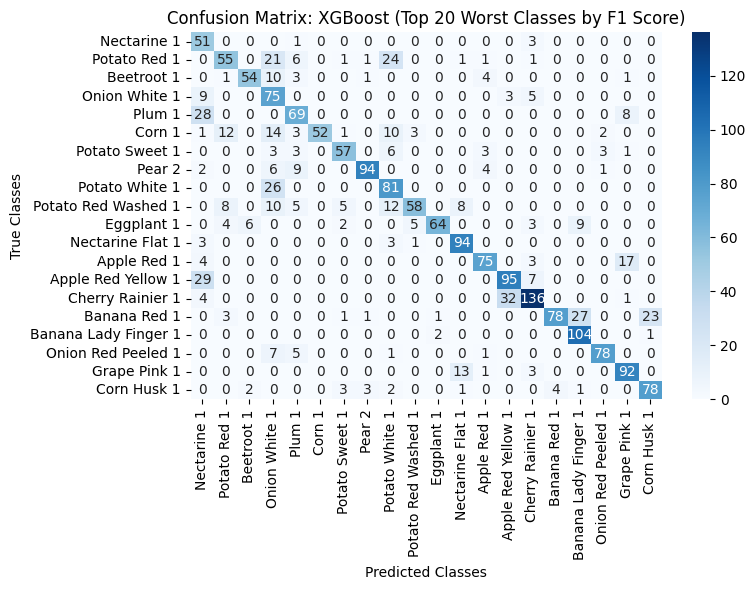

In [41]:
top_worst_classes_report(y_test, y_pred_xgb, train_dataset.classes, top_n=20, model="XGBoost")
plot_worst_classes_confusion_matrix(y_test, y_pred_xgb, train_dataset.classes, top_n=20, model="XGBoost")